In [27]:
!pip install prophet
!pip install pystan
!pip install plotly


  Using cached pystan-3.9.1-py3-none-any.whl.metadata (3.7 kB)
  Using cached aiohttp-3.9.5-cp311-cp311-win_amd64.whl.metadata (7.7 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl.metadata (1.6 kB)
INFO: pip is looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
  Using cached pystan-3.9.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached pystan-3.8.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached pystan-3.7.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached pystan-3.6.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached pystan-3.5.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached pystan-3.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached pystan-3.3.0-py3-none-any.whl.metadata (3.6 kB)
INFO: pip is still looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
  Using cached pystan-3.2.0-py3-none-any.whl.metadata (3.6 kB)
 

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\91909\AppData\Local\Temp\pip-install-u24ekhdt\pystan_e94b6ca997824d83bfffff0fc77daf95\setup.py", line 122, in <module>
          from Cython.Build.Inline import _get_build_extension
      ModuleNotFoundError: No module named 'Cython'
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Import Libraries

In [28]:
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly
import plotly.offline as py
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation, performance_metrics


# Load and Preprocess Data

In [29]:
df = pd.read_csv('C:\\Users\\91909\\OneDrive\\Desktop\\sales_prediction_project\\Global_Superstore2.csv', encoding="ISO-8859-1", parse_dates=['Order Date'])


C:\Users\91909\AppData\Local\Temp\ipykernel_11492\2590838456.py:1: UserWarning:

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



# EXAMPLE
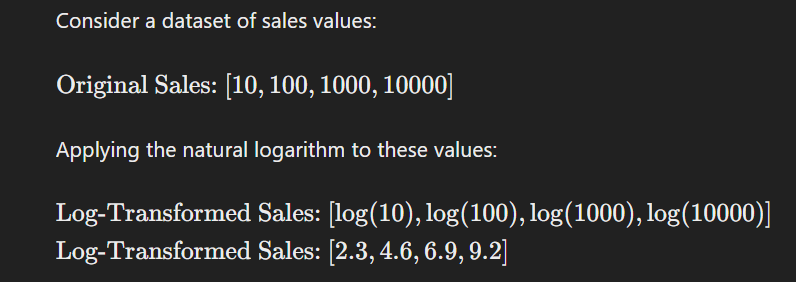

In [30]:
# Create required columns
df['ds'] = df['Order Date']
df['y_orig'] = df['Sales']
df['Sales'] = np.log(df['Sales'])
df['y'] = df['Sales']


In [31]:
# Handle missing values
df['Sales'].fillna(df['Sales'].mean(), inplace=True)
df.dropna(subset=['Order Date'], inplace=True)

C:\Users\91909\AppData\Local\Temp\ipykernel_11492\2805143900.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





1.	Row ID: A unique identifier for each row in the dataset.
2.	Order ID: The unique identifier for each order placed.
3.	Order Date: The date when the order was placed.
4.	Ship Date: The date when the order was shipped.
5.	Ship Mode: The shipping method used for the order (e.g., Same Day, Second Class, First Class).
6.	Customer ID: A unique identifier for each customer.
7.	Customer Name: The name of the customer who placed the order.
8.	Segment: The market segment to which the customer belongs (e.g., Consumer, Corporate, Home Office).
9.	City: The city where the customer is located.
10.	State: The state where the customer is located.
11.	Country: The country where the customer is located.
12.	Postal Code: The postal code of the customer's location.
13.	Market: The market region (e.g., US, APAC).
14.	Region: The broader geographic region (e.g., East, Oceania, Central, Africa).
15.	Product ID: A unique identifier for each product.
16.	Category: The product category (e.g., Technology, Furniture).
17.	Sub-Category: The sub-category of the product (e.g., Accessories, Phones).
18.	Product Name: The name of the product.
19.	Sales: The sales amount for the order (log-transformed value).
20.	Quantity: The quantity of the product ordered.
21.	Discount:The discount applied to the product in the order.
22.	Profit: The profit made from the order.
23.	Shipping Cost: The cost of shipping the order.
24.	Order Priority: The priority of the order (e.g., Critical, Medium).
25.	ds: The date column formatted for use in the Prophet model (same as Order Date).
26.	y_orig: The original sales amount before log transformation.
27.	y: The sales amount after log transformation (used for forecasting).



In [32]:
df.to_csv('df.csv', index=False)
df.head()

Row ID         Order ID Order Date   Ship Date     Ship Mode Customer ID  \
0   32298   CA-2012-124891 2012-07-31  31-07-2012      Same Day    RH-19495   
1   26341    IN-2013-77878 2013-02-05  07-02-2013  Second Class    JR-16210   
2   25330    IN-2013-71249 2013-10-17  18-10-2013   First Class    CR-12730   
3   13524  ES-2013-1579342 2013-01-28  30-01-2013   First Class    KM-16375   
4   47221     SG-2013-4320 2013-11-05  06-11-2013      Same Day     RH-9495   

      Customer Name      Segment           City            State  ...  \
0       Rick Hansen     Consumer  New York City         New York  ...   
1     Justin Ritter    Corporate     Wollongong  New South Wales  ...   
2      Craig Reiter     Consumer       Brisbane       Queensland  ...   
3  Katherine Murray  Home Office         Berlin           Berlin  ...   
4       Rick Hansen     Consumer          Dakar            Dakar  ...   

                                        Product Name     Sales Quantity  \
0  Plantronics CS510 - Over-the-Head monaural Wir...  7.744851        7   
1          Novimex Executive Leather Armchair, Black  8.218624        9   
2                  Nokia Smart Phone, with Caller ID  8.551628        9   
3                     Motorola Smart Phone, Cordless  7.969880        5   
4                     Sharp Wireless Fax, High-Speed  7.949077        8   

  Discount    Profit Shipping Cost Order Priority         ds    y_orig  \
0      0.0  762.1845        933.57       Critical 2012-07-31  2309.650   
1      0.1 -288.7650        923.63       Critical 2013-02-05  3709.395   
2      0.1  919.9710        915.49         Medium 2013-10-17  5175.171   
3      0.1  -96.5400        910.16         Medium 2013-01-28  2892.510   
4      0.0  311.5200        903.04       Critical 2013-11-05  2832.960   

          y  
0  7.744851  
1  8.218624  
2  8.551628  
3  7.969880  
4  7.949077  

[5 rows x 27 columns]

# Initialize and Fit the Prophet Model

Prophet is a forecasting tool developed by Facebook for time series data.

**seasonality_mode='multiplicative':** This specifies that the seasonal components should be multiplicative rather than additive. In multiplicative seasonality, seasonal effects scale with the level of the time series.

**changepoint_prior_scale=0.05**: This controls the flexibility of the trend. A lower value makes the trend less flexible.

**seasonality_prior_scale=10.0:** This controls the strength of the seasonality component. Higher values make the seasonality more flexible.


In [33]:
# Initialize Prophet model
model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.05, seasonality_prior_scale=10.0)


add_seasonality method is used to add custom seasonalities to the model.

**name='quarterly':** This is the name of the custom seasonality.

**period=90.5:** This indicates the period of the seasonality. Here, it represents a quarterly seasonality, assuming an average quarter length.

**fourier_order=8:** This determines the number of Fourier components to use for the seasonality. Higher values can capture more complex seasonal patterns.

In [34]:
# quarterly seasonality
model.add_seasonality(name='quarterly', period=90.5, fourier_order=8)


In [35]:
model.fit(df)

11:48:32 - cmdstanpy - INFO - Chain [1] start processing
11:48:40 - cmdstanpy - INFO - Chain [1] done processing


# Create Future Dataframe and Make Predictions

In [36]:
# Create future dataframe
future_data = model.make_future_dataframe(periods=100, freq='W')

forecast_data = model.predict(future_data)


# Back Transform Predictions

np.exp is a function from the NumPy library that computes the exponential (e^x) of all elements in the input array.

forecast_data['yhat'], forecast_data['yhat_lower'], and forecast_data['yhat_upper'] contain logarithmic values of the forecasted data and its intervals.

In [37]:
forecast_data['yhat'] = np.exp(forecast_data['yhat'])
forecast_data['yhat_lower'] = np.exp(forecast_data['yhat_lower'])
forecast_data['yhat_upper'] = np.exp(forecast_data['yhat_upper'])


1.	ds: This stands for 'datestamp' and represents the date for the forecasted value.

2.	trend: The predicted trend component of the time series. This is the underlying trend in the data without seasonal or holiday effects.

3.	yhat_lower: The lower bound of the forecasted value with the specified uncertainty interval (usually 80% by default). This gives the lower range of the prediction interval for the forecast.

4.	yhat_upper: The upper bound of the forecasted value with the specified uncertainty interval (usually 80% by default). This gives the upper range of the prediction interval for the forecast.

5.	trend_lower: The lower bound of the trend component with the specified uncertainty interval. This represents the lower range of the prediction interval for the trend.

6.	trend_upper: The upper bound of the trend component with the specified uncertainty interval. This represents the upper range of the prediction interval for the trend.

7.	multiplicative_terms: The combined effect of all multiplicative seasonal components, if any. This is relevant when the seasonalities are modeled as multiplicative rather than additive.

8.	multiplicative_terms_lower: The lower bound of the multiplicative terms with the specified uncertainty interval.

9.	multiplicative_terms_upper: The upper bound of the multiplicative terms with the specified uncertainty interval.

10.	quarterly: The quarterly seasonal component of the forecast. This term captures the quarterly seasonality effects in the time series data.

11.	quarterly_lower: The lower bound of the quarterly seasonal component with the specified uncertainty interval.

12.	quarterly_upper: The upper bound of the quarterly seasonal component with the specified uncertainty interval.

13.	weekly: The weekly seasonal component of the forecast. This term captures the weekly seasonality effects in the time series data.

14.	weekly_lower: The lower bound of the weekly seasonal component with the specified uncertainty interval.

15.	weekly_upper: The upper bound of the weekly seasonal component with the specified uncertainty interval.

16.	yearly: The yearly seasonal component of the forecast. This term captures the yearly seasonality effects in the time series data.

17.	yearly_lower: The lower bound of the yearly seasonal component with the specified uncertainty interval.

18.	yearly_upper: The upper bound of the yearly seasonal component with the specified uncertainty interval.

19.	additive_terms: The combined effect of all additive seasonal components, including weekly, quarterly, and yearly seasonality, and any other user-specified seasonalities.

20.	additive_terms_lower: The lower bound of the additive terms with the specified uncertainty interval.

21.	additive_terms_upper: The upper bound of the additive terms with the specified uncertainty interval.

22.	yhat: The predicted value of the time series at the corresponding date (ds). This is the main forecast value combining trend, seasonality, and any other components.


In [38]:
# Save the DataFrame to a CSV file
forecast_data.to_csv('forecast_data.csv', index=False)
forecast_data

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2011-01-01  4.431753   13.190734  528.365116     4.431753     4.431753   
1    2011-01-02  4.432004   11.263638  449.015445     4.432004     4.432004   
2    2011-01-03  4.432255   13.904480  515.703486     4.432255     4.432255   
3    2011-01-04  4.432506   11.821914  564.807005     4.432506     4.432506   
4    2011-01-05  4.432757   14.011795  595.487231     4.432757     4.432757   
...         ...       ...         ...         ...          ...          ...   
1525 2016-10-30  4.467827   12.373726  519.971384     4.428071     4.507517   
1526 2016-11-06  4.467796   13.229376  527.394635     4.427299     4.507868   
1527 2016-11-13  4.467766   15.201140  634.568391     4.426663     4.508646   
1528 2016-11-20  4.467736   14.750089  617.700214     4.425994     4.509245   
1529 2016-11-27  4.467706   12.997427  500.910752     4.425391     4.510055   

      multiplicative_terms  multiplicative_terms_lower  \
0                 0.004296                    0.004296   
1                -0.018137                   -0.018137   
2                -0.008540                   -0.008540   
3                -0.001850                   -0.001850   
4                -0.000493                   -0.000493   
...                    ...                         ...   
1525             -0.019219                   -0.019219   
1526             -0.015570                   -0.015570   
1527              0.009491                    0.009491   
1528              0.005833                    0.005833   
1529             -0.025196                   -0.025196   

      multiplicative_terms_upper  quarterly  ...    weekly  weekly_lower  \
0                       0.004296  -0.014309  ...  0.006444      0.006444   
1                      -0.018137  -0.014013  ... -0.015008     -0.015008   
2                      -0.008540  -0.012742  ... -0.005283     -0.005283   
3                      -0.001850  -0.011105  ...  0.001252      0.001252   
4                      -0.000493  -0.009689  ...  0.002719      0.002719   
...                          ...        ...  ...       ...           ...   
1525                   -0.019219  -0.017654  ... -0.015008     -0.015008   
1526                   -0.015570  -0.014032  ... -0.015008     -0.015008   
1527                    0.009491   0.017147  ... -0.015008     -0.015008   
1528                    0.005833   0.025243  ... -0.015008     -0.015008   
1529                   -0.025196   0.005405  ... -0.015008     -0.015008   

      weekly_upper    yearly  yearly_lower  yearly_upper  additive_terms  \
0         0.006444  0.012161      0.012161      0.012161             0.0   
1        -0.015008  0.010885      0.010885      0.010885             0.0   
2        -0.005283  0.009486      0.009486      0.009486             0.0   
3         0.001252  0.008003      0.008003      0.008003             0.0   
4         0.002719  0.006478      0.006478      0.006478             0.0   
...            ...       ...           ...           ...             ...   
1525     -0.015008  0.013443      0.013443      0.013443             0.0   
1526     -0.015008  0.013470      0.013470      0.013470             0.0   
1527     -0.015008  0.007352      0.007352      0.007352             0.0   
1528     -0.015008 -0.004402     -0.004402     -0.004402             0.0   
1529     -0.015008 -0.015592     -0.015592     -0.015592             0.0   

      additive_terms_lower  additive_terms_upper       yhat  
0                      0.0                   0.0  85.694909  
1                      0.0                   0.0  77.604147  
2                      0.0                   0.0  80.996267  
3                      0.0                   0.0  83.454737  
4                      0.0                   0.0  83.979405  
...                    ...                   ...        ...  
1525                   0.0                   0.0  79.994677  
1526                   0.0                   

# Plot the Results

In [39]:
# Plot forecast using Plotly
fig = plot_plotly(model, forecast_data)
py.iplot(fig)


c:\Users\91909\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\91909\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\91909\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on t

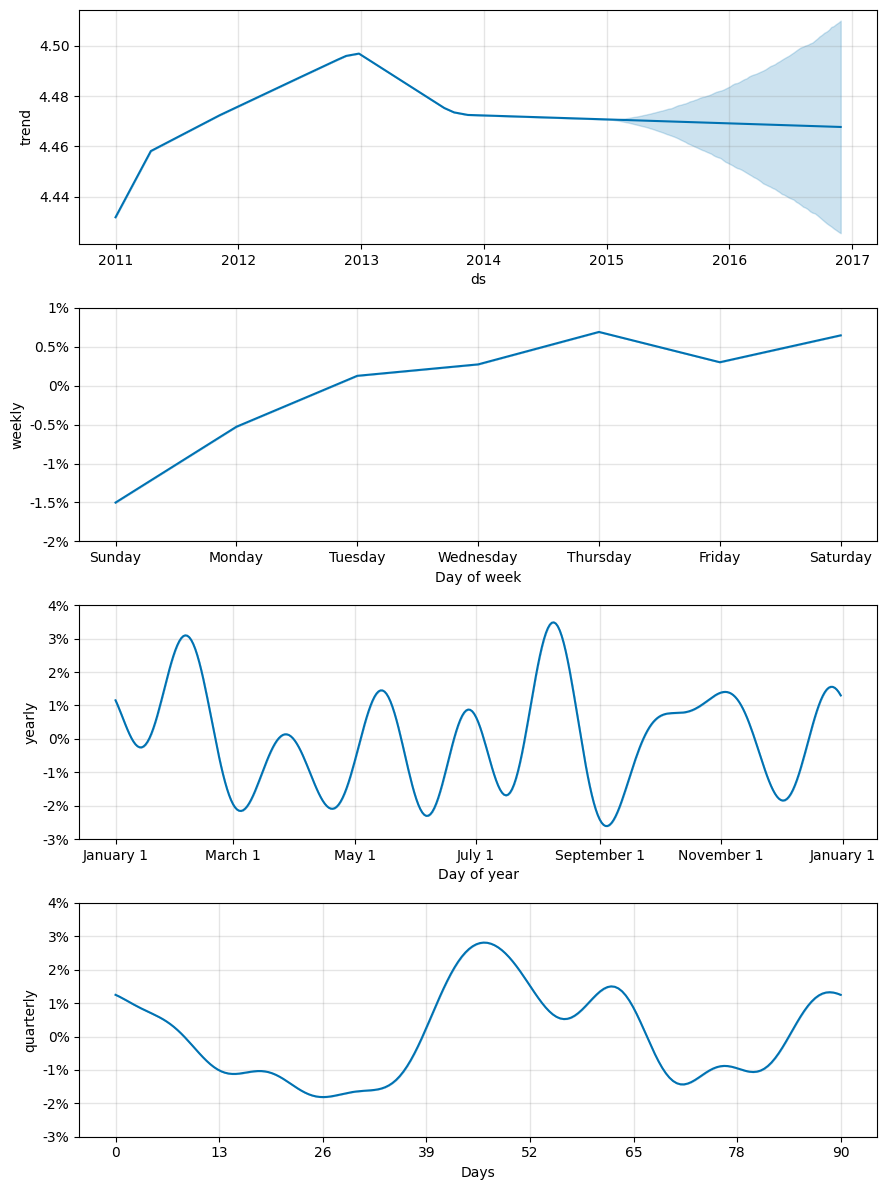

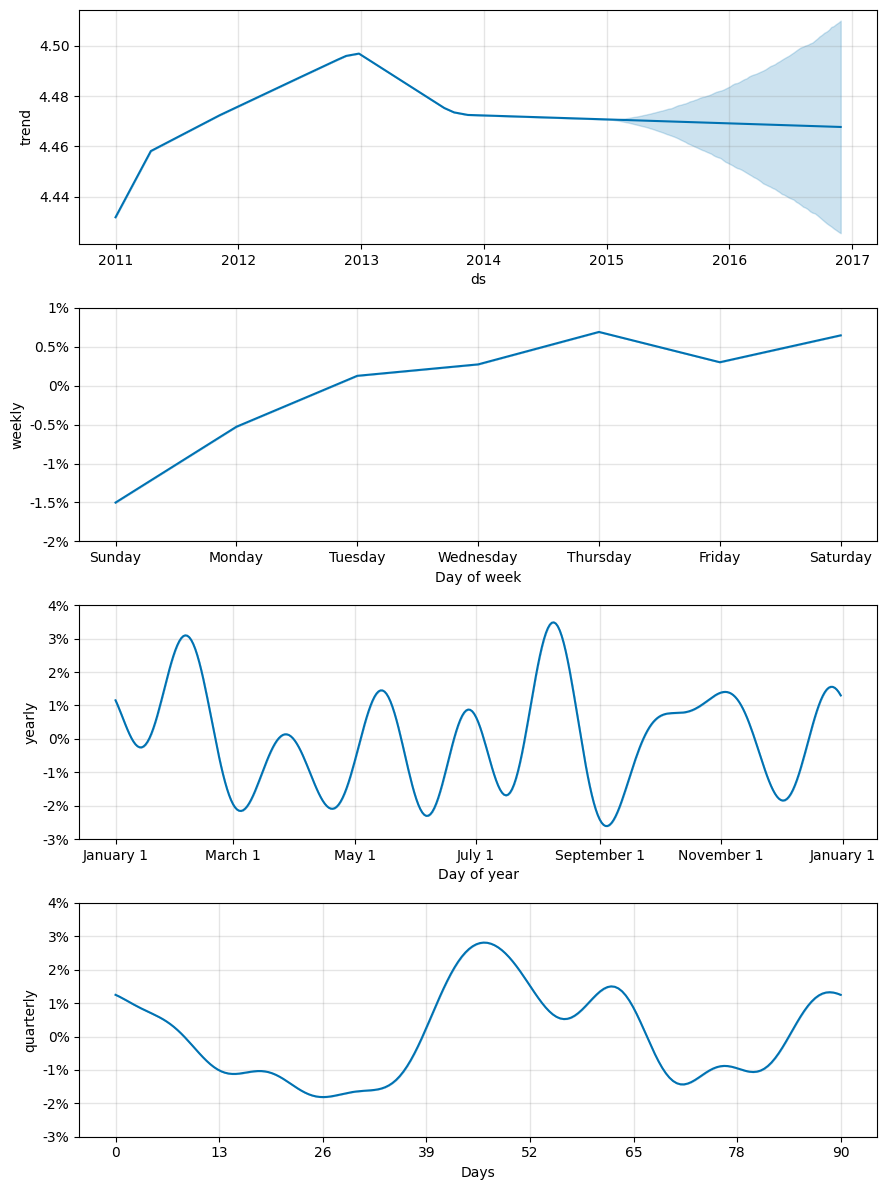

In [40]:
# Plot forecast components
model.plot_components(forecast_data)


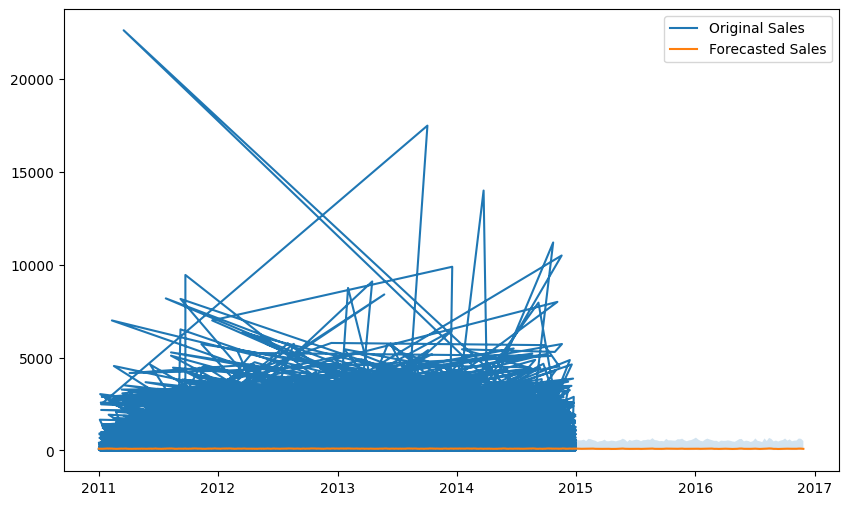

In [41]:
# Matplotlib plots
plt.figure(figsize=(10, 6))
plt.plot(df['ds'], np.exp(df['y']), label='Original Sales')
plt.plot(forecast_data['ds'], forecast_data['yhat'], label='Forecasted Sales')
plt.fill_between(forecast_data['ds'], forecast_data['yhat_lower'], forecast_data['yhat_upper'], alpha=0.2)
plt.legend()
plt.show()

# Cross-validation and Performance Metrics
Think of **cross-validation** as a way to check how well our forecasting model works on unseen data.


1. ds: This stands for "datestamp" and represents the date for the forecasted or actual value. In this example, it ranges around early January 2013.

2. yhat: This is the predicted value of the time series at the corresponding date (ds). It's the main forecasted value from Prophet.

3. yhat_lower: This is the lower bound of the forecasted value with the specified uncertainty interval (usually 80% by default). It provides the lower range of the prediction interval for the forecast, indicating that there is an 80% probability that the true value will fall between yhat_lower and yhat_upper.

4. yhat_upper: This is the upper bound of the forecasted value with the specified uncertainty interval (usually 80% by default). It provides the upper range of the prediction interval for the forecast.

5. y: This is the actual observed value of the time series for the corresponding date (ds). This is the value you are trying to predict.

6. cutoff: This represents the cutoff date for the cross-validation. The model is trained up to this date, and predictions are made for dates after this cutoff.


***Take the first 2 years of data, then simulate making forecasts every 6 months, and predict 1 year into the future each time.***

In [42]:
# Cross-validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
df_cv.head()


  0%|          | 0/3 [00:00<?, ?it/s]11:48:48 - cmdstanpy - INFO - Chain [1] start processing
11:48:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:09<00:18,  9.34s/it]11:48:58 - cmdstanpy - INFO - Chain [1] start processing
11:49:00 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:19<00:10, 10.06s/it]11:49:09 - cmdstanpy - INFO - Chain [1] start processing
11:49:14 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:33<00:00, 11.32s/it]


ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2013-01-06  4.514970    2.415588    6.338909  4.594716 2013-01-05
1 2013-01-07  4.569957    2.724850    6.323982  3.255015 2013-01-05
2 2013-01-07  4.569957    2.787103    6.483450  5.159400 2013-01-05
3 2013-01-07  4.569957    2.521437    6.432931  2.030776 2013-01-05
4 2013-01-07  4.569957    2.722350    6.491507  3.442531 2013-01-05

1. horizon: This represents the forecast horizon, i.e., the number of days into the future that the forecast is made.

2. mse (Mean Squared Error): This is the average of the squares of the differences between the predicted values (yhat) and the actual values (y). It measures the average squared difference between the estimated values and the actual value. A lower MSE indicates a better fit.

3. rmse (Root Mean Squared Error): This is the square root of the Mean Squared Error (MSE). It provides the error in the same units as the original data. RMSE is more interpretable as it is in the same scale as the data.

4. mae (Mean Absolute Error): This is the average of the absolute differences between the predicted values and the actual values. It measures the average magnitude of the errors in a set of predictions, without considering their direction. A lower MAE indicates a better fit.

5. mape (Mean Absolute Percentage Error): This is the average of the absolute percentage differences between the predicted values and the actual values. It expresses accuracy as a percentage, and a lower MAPE indicates a better fit.

6. mdape (Median Absolute Percentage Error): This is the median of the absolute percentage differences between the predicted values and the actual values. It is less sensitive to outliers compared to MAPE.

7. smape (Symmetric Mean Absolute Percentage Error): This is an alternative to MAPE, which is calculated as the average of the absolute differences divided by the average of the actual and predicted values. It treats overestimation and underestimation equally.

8. coverage: This indicates the proportion of the time that the actual values fall within the forecast uncertainty intervals (typically 80% or 95%). Higher coverage values indicate that the model's uncertainty intervals are well-calibrated and capture the true values more frequently.

In [43]:
# Performance metrics
df_p = performance_metrics(df_cv)
print(df_p)


     horizon       mse      rmse       mae      mape     mdape     smape  \
0    54 days  2.165934  1.471711  1.204940  0.348289  0.226846  0.280377   
1    55 days  2.154970  1.467982  1.200944  0.346143  0.226218  0.279179   
2    56 days  2.142499  1.463728  1.197168  0.344023  0.225970  0.278135   
3    57 days  2.133766  1.460741  1.193561  0.344799  0.224469  0.277359   
4    58 days  2.141567  1.463409  1.195591  0.345403  0.225348  0.277526   
..       ...       ...       ...       ...       ...       ...       ...   
307 361 days  2.135124  1.461206  1.190987  0.367714  0.226583  0.279695   
308 362 days  2.143468  1.464059  1.193909  0.369415  0.226492  0.280573   
309 363 days  2.166665  1.471960  1.199225  0.378829  0.226870  0.282153   
310 364 days  2.162427  1.470519  1.198498  0.378459  0.226401  0.282051   
311 365 days  2.161503  1.470205  1.198112  0.378337  0.226583  0.281829   

     coverage  
0    0.783876  
1    0.784311  
2    0.785796  
3    0.788004  
4    0.

# Optional Hold-out Validation

In [44]:
# Split data into training and test sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


In [45]:
# Reinitialize and fit the model on the training set
model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.05, seasonality_prior_scale=10.0)
model.add_seasonality(name='quarterly', period=90.5, fourier_order=8)
model.fit(train)


11:49:24 - cmdstanpy - INFO - Chain [1] start processing
11:49:30 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
# Create future dataframe for the test period
future_data = model.make_future_dataframe(periods=len(test), freq='D')
forecast_data = model.predict(future_data)


In [47]:
# Back transform predictions
forecast_data['yhat'] = np.exp(forecast_data['yhat'])


ValueError: x and y must be the same size

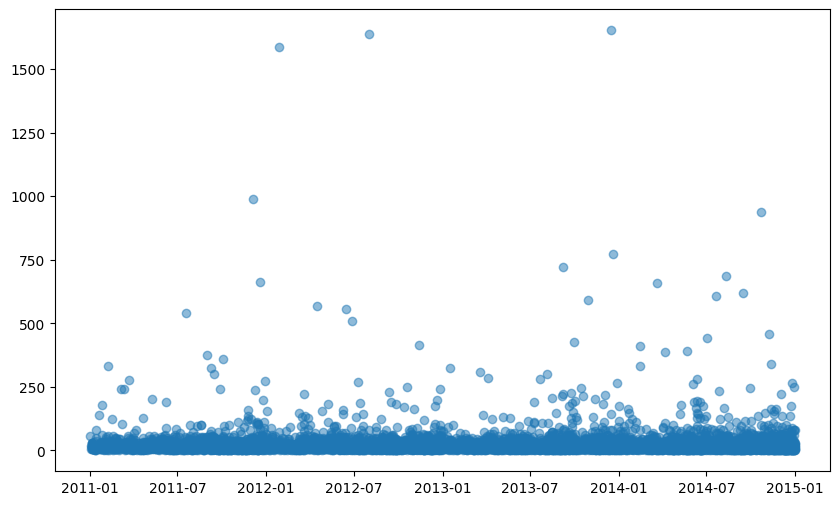

In [48]:
# # Plot actual vs. predicted sales using scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(test['ds'], np.exp(test['y']), label='Actual Sales', alpha=0.5)
# plt.scatter(forecast_data['ds'], forecast_data['yhat'].iloc[-len(test):], label='Predicted Sales', alpha=0.5)
# plt.legend()
# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.title('Actual vs Predicted Sales')
# plt.show()